In [14]:
hmargs = {
    'aprx': 'paca',
    'basis': 'linear',
    'admis': '2',
    'eta': 1.2,
    'm': 4,
    'clf': 32,
    'eps_aca': 1e-2,     
    'q_reg': 2,
    'q_sing': 4,
}
refn = 7
f = 1e6
c = 1500
rho = 1000
n_start = 1
n_stop = 20
n_step = 2

100%|██████████| 11/11 [02:38<00:00, 22.32s/it]


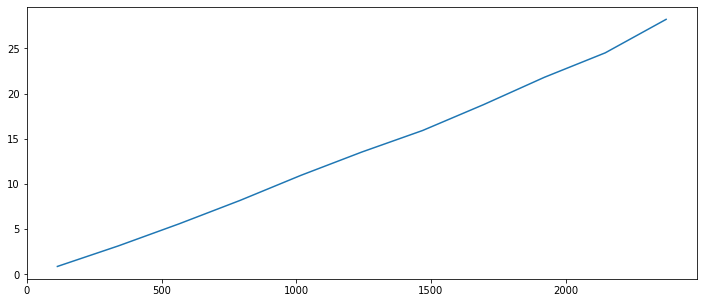

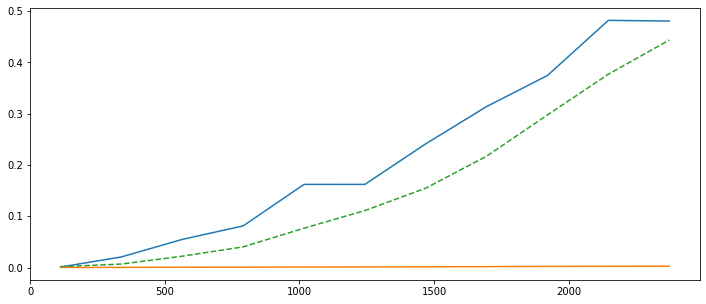

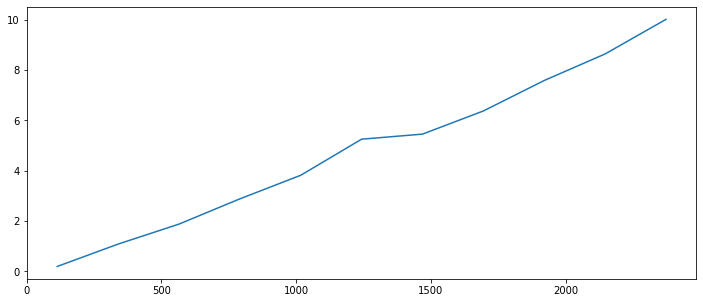

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from numpy.linalg import norm
from timeit import default_timer as timer

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array
from cnld.compressed_formats import MbkSparseMatrix


ns = np.arange(n_start, n_stop + n_step, n_step)
time_assemble = np.zeros(len(ns))
time_lu = np.zeros(len(ns))
time_solve = np.zeros(len(ns))
size = np.zeros(len(ns))
nodes = np.zeros(len(ns))
mems = np.zeros(len(ns))

for i, n in enumerate(tqdm(ns)):
    
    array = matrix_array(nelem=[1,n], shape='circle')
    amesh = mesh.Mesh.from_abstract(array, refn)

    Gfe = MbkSparseMatrix(fem.array_mbk_spmatrix(array, refn, f))
    b = np.array(fem.array_f_spmatrix(array, refn)[:,0].todense())

    omg = 2 * np.pi * f
    k = omg / c
    Z = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    G = Gfe + -omg**2 * 2 * rho * Z

    start = timer()
    Glu = G.lu()
    time_lu[i] = timer() - start
    
    start = timer()
    xhm = np.conj(Glu.lusolve(b))
    xhm[amesh.on_boundary] = 0
    time_solve[i] = timer() - start
    
    time_assemble[i] = Z.time_assemble
    size[i] = Z.size
    nodes[i] = amesh.nvertices
    mems[i] = n
    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, time_assemble)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, time_lu)
ax.plot(nodes, time_solve)
ax.plot(nodes, time_solve * mems * 8, '--')

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, size / 1024 / 1024)

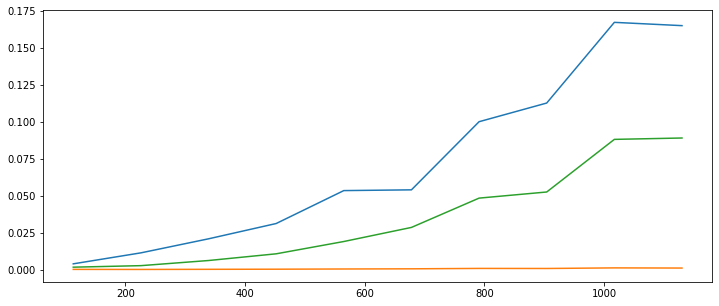

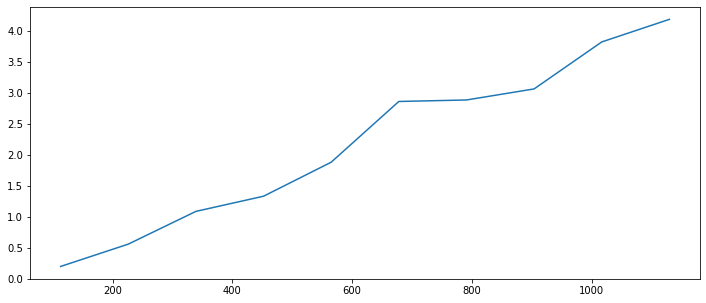

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, time_assemble)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, time_lu)
ax.plot(nodes, time_solve)
ax.plot(nodes, time_solve * mems * 8, '--')

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(nodes, size / 1024 / 1024)